# SFScores - Predicting the Results of Health Inspections of Restaurants

In this notebook, we will benchmark several of getML's feature learning algorithms against featuretools using a dataset of eateries in San Francisco.

Summary:

- Prediction type: __Regression model__
- Domain: __Health__
- Prediction target: __Sales__ 
- Population size: __12887__

_Author: Dr. Patrick Urbanke_

# Background

This notebook is based on the San Francisco Dept. of Public Health's database of eateries in San Francisco. These eateries are regularly inspected. The inspections often result in a score.

The challenge is to predict the score resulting from an inspection.

The dataset has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/SFScores) (Motl and Schulte, 2015).

We will benchmark [getML](https://www.getml.com) 's feature learning algorithms against [featuretools](https://www.featuretools.com), an open-source implementation of the propositionalization algorithm, similar to getML's FastProp.

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set up your session:

In [55]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import featuretools
import getml

getml.engine.set_project('sfscores')



Connected to project 'sfscores'


## 1. Loading data

### 1.1 Download from source

We begin by downloading the data:

In [2]:
conn = getml.database.connect_mariadb(
    host="relational.fit.cvut.cz",
    dbname="SFScores",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(conn_id='default',
           dbname='SFScores',
           dialect='mysql',
           host='relational.fit.cvut.cz',
           port=3306)

In [3]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [4]:
businesses = load_if_needed("businesses")
inspections = load_if_needed("inspections")
violations = load_if_needed("violations")

In [5]:
businesses

name,business_id,postal_code,tax_code,owner_zip,name,latitude,longitude,phone_number,business_certificate,address,city,application_date,owner_name,owner_address,owner_city,owner_state
role,join_key,categorical,categorical,categorical,text,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,10,94104,H24,94104,Tiramisu Kitchen,37.7911,-122.404,nan,779059,033 Belden Pl,San Francisco,NULL,Tiramisu LLC,33 Belden St,San Francisco,CA
1,24,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry,37.7929,-122.403,nan,352312,"500 California St, 2nd Floor",San Francisco,NULL,OMNI San Francisco Hotel Corp,"500 California St, 2nd Floor",San Francisco,CA
2,31,94133,H24,94133,Norman's Ice Cream and Freezes,37.8072,-122.419,nan,346882,2801 Leavenworth St,San Francisco,NULL,Norman Antiforda,2801 Leavenworth St,San Francisco,CA
3,45,94110,H24,94114,CHARLIE'S DELI CAFE,37.7471,-122.414,nan,340024,3202 FOLSOM St,S.F.,2001-10-10,"HARB, CHARLES AND KRISTIN",1150 SANCHEZ,S.F.,CA
4,48,94122,H24,94122,ART'S CAFE,37.764,-122.466,nan,318022,747 IRVING St,SAN FRANCISCO,NULL,YOON HAE RYONG,1567 FUNSTON AVE,SAN FRANCISCO,CA
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6353,89335,94102,H25,94102,Breaking Bad Sandwiches,nan,nan,nan,1057025,154 McAllister St,NULL,2016-09-23,"JPMD, LLC",662 Bellhurst Lane,Castro Valley,CA
6354,89336,94109,H26,94109,Miller's Rest,nan,nan,nan,1057746,1085 Sutter St,NULL,2016-09-23,"Miller's Rest, LLC",2906 Bush Street,San Francisco,CA
6355,89393,94133,H24,94122,Panuchos,nan,nan,nan,1042408,620 Broadway St,NULL,2016-09-28,"Los Aluxes, LLC","1032 Irving Street, #421",San Francisco,CA


In [6]:
inspections

name,date,business_id,score,type
role,time_stamp,join_key,target,unused_string
unit,"time stamp, comparison only",,,
0,2014-01-14,10,92,Routine - Unscheduled
1,2014-07-29,10,94,Routine - Unscheduled
2,2016-05-03,10,82,Routine - Unscheduled
3,2013-11-18,24,100,Routine - Unscheduled
4,2014-06-12,24,96,Routine - Unscheduled
,...,...,...,...
12882,2016-09-22,89072,90,Routine - Unscheduled
12883,2016-09-12,89198,100,Routine - Unscheduled


In [7]:
violations

name,date,business_id,violation_type_id,risk_category,description
role,time_stamp,join_key,categorical,categorical,text
unit,"time stamp, comparison only",,,,
0,2014-07-29,10,103129,Moderate Risk,Insufficient hot water or running water
1,2014-07-29,10,103144,Low Risk,Unapproved or unmaintained equipment or utensils
2,2014-01-14,10,103119,Moderate Risk,Inadequate and inaccessible handwashing facilities
3,2014-01-14,10,103145,Low Risk,Improper storage of equipment utensils or linens
4,2014-01-14,10,103154,Low Risk,Unclean or degraded floors walls or ceilings
,...,...,...,...,...
36045,2016-08-19,88878,103144,Low Risk,Unapproved or unmaintained equipment or utensils
36046,2016-08-19,88878,103124,Moderate Risk,Inadequately cleaned or sanitized food contact surfaces


### 1.2 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [8]:
businesses.set_role("business_id", getml.data.roles.join_key)
businesses.set_role("name", getml.data.roles.text)
businesses.set_role(["postal_code", "tax_code", "owner_zip"], getml.data.roles.categorical)

businesses

name,business_id,postal_code,tax_code,owner_zip,name,latitude,longitude,phone_number,business_certificate,address,city,application_date,owner_name,owner_address,owner_city,owner_state
role,join_key,categorical,categorical,categorical,text,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,10,94104,H24,94104,Tiramisu Kitchen,37.7911,-122.404,nan,779059,033 Belden Pl,San Francisco,NULL,Tiramisu LLC,33 Belden St,San Francisco,CA
1,24,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry,37.7929,-122.403,nan,352312,"500 California St, 2nd Floor",San Francisco,NULL,OMNI San Francisco Hotel Corp,"500 California St, 2nd Floor",San Francisco,CA
2,31,94133,H24,94133,Norman's Ice Cream and Freezes,37.8072,-122.419,nan,346882,2801 Leavenworth St,San Francisco,NULL,Norman Antiforda,2801 Leavenworth St,San Francisco,CA
3,45,94110,H24,94114,CHARLIE'S DELI CAFE,37.7471,-122.414,nan,340024,3202 FOLSOM St,S.F.,2001-10-10,"HARB, CHARLES AND KRISTIN",1150 SANCHEZ,S.F.,CA
4,48,94122,H24,94122,ART'S CAFE,37.764,-122.466,nan,318022,747 IRVING St,SAN FRANCISCO,NULL,YOON HAE RYONG,1567 FUNSTON AVE,SAN FRANCISCO,CA
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6353,89335,94102,H25,94102,Breaking Bad Sandwiches,nan,nan,nan,1057025,154 McAllister St,NULL,2016-09-23,"JPMD, LLC",662 Bellhurst Lane,Castro Valley,CA
6354,89336,94109,H26,94109,Miller's Rest,nan,nan,nan,1057746,1085 Sutter St,NULL,2016-09-23,"Miller's Rest, LLC",2906 Bush Street,San Francisco,CA
6355,89393,94133,H24,94122,Panuchos,nan,nan,nan,1042408,620 Broadway St,NULL,2016-09-28,"Los Aluxes, LLC","1032 Irving Street, #421",San Francisco,CA


In [9]:
inspections = inspections[~inspections.score.is_nan()].to_df("inspections")

inspections.set_role("business_id", getml.data.roles.join_key)
inspections.set_role("score", getml.data.roles.target)
inspections.set_role("date", getml.data.roles.time_stamp)

inspections

name,date,business_id,score,type
role,time_stamp,join_key,target,unused_string
unit,"time stamp, comparison only",,,
0,2014-01-14,10,92,Routine - Unscheduled
1,2014-07-29,10,94,Routine - Unscheduled
2,2016-05-03,10,82,Routine - Unscheduled
3,2013-11-18,24,100,Routine - Unscheduled
4,2014-06-12,24,96,Routine - Unscheduled
,...,...,...,...
12882,2016-09-22,89072,90,Routine - Unscheduled
12883,2016-09-12,89198,100,Routine - Unscheduled


In [10]:
violations.set_role("business_id", getml.data.roles.join_key)
violations.set_role("date", getml.data.roles.time_stamp)
violations.set_role(["violation_type_id", "risk_category"], getml.data.roles.categorical)
violations.set_role("description", getml.data.roles.text)

violations

name,date,business_id,violation_type_id,risk_category,description
role,time_stamp,join_key,categorical,categorical,text
unit,"time stamp, comparison only",,,,
0,2014-07-29,10,103129,Moderate Risk,Insufficient hot water or running water
1,2014-07-29,10,103144,Low Risk,Unapproved or unmaintained equipment or utensils
2,2014-01-14,10,103119,Moderate Risk,Inadequate and inaccessible handwashing facilities
3,2014-01-14,10,103145,Low Risk,Improper storage of equipment utensils or linens
4,2014-01-14,10,103154,Low Risk,Unclean or degraded floors walls or ceilings
,...,...,...,...,...
36045,2016-08-19,88878,103144,Low Risk,Unapproved or unmaintained equipment or utensils
36046,2016-08-19,88878,103124,Moderate Risk,Inadequately cleaned or sanitized food contact surfaces


## 2. Predictive modeling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

In [11]:
split = getml.data.split.random(train=0.8, test=0.2)

### 2.1 Define relational model

In [12]:
star_schema = getml.data.StarSchema(population=inspections, alias="population", split=split)

star_schema.join(
    businesses,
    on="business_id",
    relationship=getml.data.relationship.many_to_one
)

star_schema.join(
    violations,
    on="business_id",
    time_stamps="date",
)

star_schema.join(
    inspections,
    on="business_id",
    time_stamps="date",
    lagged_targets=True,
    horizon=getml.data.time.days(1),
)

star_schema

### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We use the relboost algorithms for this problem. Because of the large number of keywords, we regularize the model a bit by requiring a minimum support for the keywords (`min_num_samples`).

In [13]:
mapping = getml.preprocessors.Mapping()

fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    aggregation=getml.feature_learning.FastProp.agg_sets.All,
    num_threads=1,
)

relboost = getml.feature_learning.Relboost(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_threads=1,
)

relmt = getml.feature_learning.RelMT(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_threads=1,
)

predictor = getml.predictors.XGBoostRegressor(n_jobs=1)

__Build the pipeline__

In [14]:
pipe1 = getml.pipeline.Pipeline(
    tags=['fast_prop'],
    data_model=star_schema.data_model,
    preprocessors=[mapping],
    feature_learners=[fast_prop],
    predictors=[predictor]
)

pipe1

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop'])

In [15]:
pipe2 = getml.pipeline.Pipeline(
    tags=['relboost'],
    data_model=star_schema.data_model,
    preprocessors=[mapping],
    feature_learners=[relboost],
    predictors=[predictor]
)

pipe2

Pipeline(data_model='population',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relboost'])

In [16]:
pipe3 = getml.pipeline.Pipeline(
    tags=['relmt'],
    data_model=star_schema.data_model,
    preprocessors=[mapping],
    feature_learners=[relmt],
    predictors=[predictor]
)

pipe3

Pipeline(data_model='population',
         feature_learners=['RelMT'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relmt'])

### 2.3 Model training

In [17]:
pipe1.check(star_schema.train)

Checking data model...


Preprocessing...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


In [18]:
pipe1.fit(star_schema.train)

Checking data model...


INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


Preprocessing...
[========================================] 100%

Indexing text fields...
[========================================] 100%

FastProp: Trying 295 features...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:12.322283



Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'container-ntpiF6'])

url: http://localhost:1709/#/getpipeline/sfscores/uyVapX/0/

In [19]:
pipe2.check(star_schema.train)

Checking data model...


Preprocessing...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


In [20]:
pipe2.fit(star_schema.train)

Checking data model...


INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


Preprocessing...
[========================================] 100%

Indexing text fields...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:31.506982



Pipeline(data_model='population',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relboost', 'container-ntpiF6'])

url: http://localhost:1709/#/getpipeline/sfscores/IURSwl/0/

In [21]:
pipe3.check(star_schema.train)

Checking data model...


Preprocessing...
[========================================] 100%

INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


In [22]:
pipe3.fit(star_schema.train)

Checking data model...


INFO [FOREIGN KEYS NOT FOUND]: When joining POPULATION__STAGING_TABLE_1 and VIOLATIONS__STAGING_TABLE_3 over 'business_id' and 'business_id', there are no corresponding entries for 5.685426% of entries in 'business_id' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys.


Preprocessing...
[========================================] 100%

Indexing text fields...
[========================================] 100%

RelMT: Training features...
[========================================] 100%

RelMT: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:35.709418



Pipeline(data_model='population',
         feature_learners=['RelMT'],
         feature_selectors=[],
         include_categorical=False,
         loss_function=None,
         peripheral=['businesses', 'inspections', 'violations'],
         predictors=['XGBoostRegressor'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relmt', 'container-ntpiF6'])

url: http://localhost:1709/#/getpipeline/sfscores/3dIZOz/0/

### 2.4 Model evaluation

In [23]:
pipe1.score(star_schema.test)



Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-07-15 16:14:49,train,score,0.466,1.1426,0.9804
1,2021-07-15 16:15:58,test,score,0.534,1.4464,0.9703


In [24]:
pipe2.score(star_schema.test)



Preprocessing...
[========================================] 100%

Relboost: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-07-15 16:15:21,train,score,0.3605,0.9646,0.986
1,2021-07-15 16:15:59,test,score,0.4537,1.4053,0.9719


In [25]:
pipe3.score(star_schema.test)



Preprocessing...
[========================================] 100%

RelMT: Building features...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-07-15 16:15:57,train,score,0.2276,0.9462,0.9865
1,2021-07-15 16:16:00,test,score,0.2967,1.3493,0.9741


### 2.5 featuretools

In [26]:
population_train_pd = star_schema.train.population.to_pandas()
population_test_pd = star_schema.test.population.to_pandas()

In [27]:
inspections_pd = inspections.drop(inspections.unused_names).to_pandas()
violations_pd = violations.drop(violations.unused_names).to_pandas()
businesses_pd = businesses.drop(businesses.unused_names).to_pandas()

In [28]:
population_train_pd["id"] = population_train_pd.index

population_train_pd = population_train_pd.merge(
    businesses_pd,
    on="business_id"
)

population_train_pd

,date,business_id,score,id,postal_code,tax_code,owner_zip,name
0,2014-01-14,10,92.0,0,94104,H24,94104,Tiramisu Kitchen
1,2014-07-29,10,94.0,1,94104,H24,94104,Tiramisu Kitchen
2,2016-05-03,10,82.0,2,94104,H24,94104,Tiramisu Kitchen
3,2014-06-12,24,96.0,3,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry
4,2014-11-24,24,96.0,4,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry
...,...,...,...,...,...,...,...,...
10390,2016-08-19,88878,94.0,10390,94102,H24,94566,Jamba Juice
10391,2016-09-22,89072,90.0,10391,94109,H91,94109,Epicurean at Sacred Heart Catholic Prep School
10392,2016-09-12,89198,100.0,10392,94107,H36,29615,"AT&T Park - Beer Cart/View Level, Sec. 333"
10393,2016-09-12,89199,100.0,10393,94107,H36,29615,"AT&T Park - Beer Cart/Lower CF, Sec. 140"


In [29]:
population_test_pd["id"] = population_test_pd.index

population_test_pd = population_test_pd.merge(
    businesses_pd,
    on="business_id"
)

population_test_pd

,date,business_id,score,id,postal_code,tax_code,owner_zip,name
0,2013-11-18,24,100.0,0,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry
1,2016-03-11,24,96.0,1,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry
2,2013-12-09,45,94.0,2,94110,H24,94114,CHARLIE'S DELI CAFE
3,2014-07-25,58,78.0,3,94111,H24,94111,Oasis Grill
4,2014-05-19,66,91.0,4,94122,H24,94122,STARBUCKS
...,...,...,...,...,...,...,...,...
2487,2016-06-07,87802,91.0,2487,94110,H25,94110,Bernal Heights Pizzeria
2488,2016-08-30,88082,84.0,2488,94133,H24,94133,Chongqing Xiaomian
2489,2016-08-17,88447,96.0,2489,NULL,H91,94107,Fare Resources
2490,2016-08-15,88702,96.0,2490,94118,H25,94118,Dancing Bull


In [30]:
def prepare_violations(violations_pd, train_or_test):
    """
    Helper function that imitates the behavior of 
    the data model defined above.
    """
    violations_new = violations_pd.merge(
        train_or_test[["id", "business_id", "date"]],
        on="business_id"
    )

    violations_new = violations_new[
        violations_new["date_x"] <= violations_new["date_y"]
    ]

    del violations_new["date_y"]
    del violations_new["business_id"]

    return violations_new.rename(columns={"date_x": "date"})

In [31]:
violations_train_pd = prepare_violations(violations_pd, population_train_pd)
violations_test_pd = prepare_violations(violations_pd, population_test_pd)
violations_train_pd

,date,violation_type_id,risk_category,description,id
1,2014-07-29,103129,Moderate Risk,Insufficient hot water or running water,1
2,2014-07-29,103129,Moderate Risk,Insufficient hot water or running water,2
4,2014-07-29,103144,Low Risk,Unapproved or unmaintained equipment or utensils,1
5,2014-07-29,103144,Low Risk,Unapproved or unmaintained equipment or utensils,2
6,2014-01-14,103119,Moderate Risk,Inadequate and inaccessible handwashing facili...,0
...,...,...,...,...,...
89483,2016-08-19,103144,Low Risk,Unapproved or unmaintained equipment or utensils,10390
89484,2016-08-19,103124,Moderate Risk,Inadequately cleaned or sanitized food contact...,10390
89485,2016-09-22,103120,Moderate Risk,Moderate risk food holding temperature,10391
89486,2016-09-22,103131,Moderate Risk,Moderate risk vermin infestation,10391


In [32]:
def prepare_inspections(inspections_pd, train_or_test):
    """
    Helper function that imitates the behavior of 
    the data model defined above.
    """
    inspections_new = inspections_pd.merge(
        train_or_test[["id", "business_id", "date"]],
        on="business_id"
    )

    inspections_new = inspections_new[
        inspections_new["date_x"] < inspections_new["date_y"]
    ]
    
    del inspections_new["date_y"]
    del inspections_new["business_id"]

    return inspections_new.rename(columns={"date_x": "date"})

In [33]:
inspections_train_pd = prepare_inspections(inspections_pd, population_train_pd)
inspections_test_pd = prepare_inspections(inspections_pd, population_test_pd)
inspections_train_pd

,date,score,id
1,2014-01-14,92.0,1
2,2014-01-14,92.0,2
5,2014-07-29,94.0,2
9,2013-11-18,100.0,3
10,2013-11-18,100.0,4
...,...,...,...
32628,2016-02-16,92.0,10290
32648,2016-04-04,96.0,10308
32673,2016-04-11,94.0,10331
32707,2016-05-23,100.0,10360


In [34]:
del population_train_pd["business_id"]
del population_test_pd["business_id"]

In [35]:
population_train_pd

,date,score,id,postal_code,tax_code,owner_zip,name
0,2014-01-14,92.0,0,94104,H24,94104,Tiramisu Kitchen
1,2014-07-29,94.0,1,94104,H24,94104,Tiramisu Kitchen
2,2016-05-03,82.0,2,94104,H24,94104,Tiramisu Kitchen
3,2014-06-12,96.0,3,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry
4,2014-11-24,96.0,4,94104,H24,94104,OMNI S.F. Hotel - 2nd Floor Pantry
...,...,...,...,...,...,...,...
10390,2016-08-19,94.0,10390,94102,H24,94566,Jamba Juice
10391,2016-09-22,90.0,10391,94109,H91,94109,Epicurean at Sacred Heart Catholic Prep School
10392,2016-09-12,100.0,10392,94107,H36,29615,"AT&T Park - Beer Cart/View Level, Sec. 333"
10393,2016-09-12,100.0,10393,94107,H36,29615,"AT&T Park - Beer Cart/Lower CF, Sec. 140"


In [36]:
entities_train = {
    "population" : (population_train_pd, "id"),
    "inspections" : (inspections_train_pd, "index"),
    "violations" : (violations_train_pd, "index")
}

In [37]:
entities_test = {
    "population" : (population_test_pd, "id"),
    "inspections" : (inspections_test_pd, "index"),
    "violations" : (violations_test_pd, "index")
}

In [38]:
relationships = [
    ("population", "id", "inspections", "id"),
    ("population", "id", "violations", "id")
]

In [39]:
featuretools_train_pd = featuretools.dfs(
    entities=entities_train,
    relationships=relationships,
    target_entity="population")[0]

/home/patrick/.local/lib/python3.9/site-packages/featuretools/entityset/entity.py:462: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn("index {} not found in dataframe, creating new "


In [40]:
featuretools_test_pd = featuretools.dfs(
    entities=entities_test,
    relationships=relationships,
    target_entity="population")[0]

In [41]:
featuretools_train = getml.data.DataFrame.from_pandas(featuretools_train_pd, "featuretools_train")
featuretools_test = getml.data.DataFrame.from_pandas(featuretools_train_pd, "featuretools_test")

In [42]:
featuretools_train.set_role("name", getml.data.roles.text)
featuretools_train.set_role("score", getml.data.roles.target)
featuretools_train.set_role(featuretools_train.unused_float_names, getml.data.roles.numerical)
featuretools_train.set_role(featuretools_train.unused_string_names, getml.data.roles.categorical)

featuretools_train

name,score,postal_code,tax_code,owner_zip,MODE(violations.description),MODE(violations.risk_category),MODE(violations.violation_type_id),COUNT(inspections),MAX(inspections.score),MEAN(inspections.score),MIN(inspections.score),SKEW(inspections.score),STD(inspections.score),SUM(inspections.score),COUNT(violations),NUM_UNIQUE(violations.description),NUM_UNIQUE(violations.risk_category),NUM_UNIQUE(violations.violation_type_id),DAY(date),MONTH(date),WEEKDAY(date),YEAR(date),MODE(inspections.DAY(date)),MODE(inspections.MONTH(date)),MODE(inspections.WEEKDAY(date)),MODE(inspections.YEAR(date)),NUM_UNIQUE(inspections.DAY(date)),NUM_UNIQUE(inspections.MONTH(date)),NUM_UNIQUE(inspections.WEEKDAY(date)),NUM_UNIQUE(inspections.YEAR(date)),MODE(violations.DAY(date)),MODE(violations.MONTH(date)),MODE(violations.WEEKDAY(date)),MODE(violations.YEAR(date)),NUM_UNIQUE(violations.DAY(date)),NUM_UNIQUE(violations.MONTH(date)),NUM_UNIQUE(violations.WEEKDAY(date)),NUM_UNIQUE(violations.YEAR(date)),name
role,target,categorical,categorical,categorical,categorical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,text
0,92,94104,H24,94104,Improper storage of equipment utensils or linens,Low Risk,103119,0,nan,nan,nan,nan,nan,0,3,3,2,3,14,1,1,2014,nan,nan,nan,nan,nan,nan,nan,nan,14,1,1,2014,1,1,1,1,Tiramisu Kitchen
1,94,94104,H24,94104,Improper storage of equipment utensils or linens,Low Risk,103119,1,92,92,92,nan,nan,92,5,5,2,5,29,7,1,2014,14,1,1,2014,1,1,1,1,14,1,1,2014,2,2,1,1,Tiramisu Kitchen
2,82,94104,H24,94104,High risk food holding temperature,Low Risk,103103,2,94,93,92,nan,1.4142,186,10,8,3,8,3,5,1,2016,14,1,1,2014,2,2,1,1,3,5,1,2014,3,3,1,2,Tiramisu Kitchen
3,96,94104,H24,94104,Improper storage of equipment utensils or linens,Low Risk,103145,1,100,100,100,nan,nan,100,2,2,1,2,12,6,3,2014,18,11,0,2013,1,1,1,1,12,6,3,2014,1,1,1,1,OMNI S.F. Hotel - 2nd Floor Pantry
4,96,94104,H24,94104,Improper storage of equipment utensils or linens,Low Risk,103119,2,100,98,96,nan,2.8284,196,3,3,2,3,24,11,0,2014,12,6,0,2013,2,2,2,2,12,6,3,2014,2,2,2,1,OMNI S.F. Hotel - 2nd Floor Pantry
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10390,94,94102,H24,94566,Inadequately cleaned or sanitized food contact surfaces,Low Risk,103124,0,nan,nan,nan,nan,nan,0,2,2,2,2,19,8,4,2016,nan,nan,nan,nan,nan,nan,nan,nan,19,8,4,2016,1,1,1,1,Jamba Juice
10391,90,94109,H91,94109,Moderate risk food holding temperature,Moderate Risk,103120,0,nan,nan,nan,nan,nan,0,3,3,2,3,22,9,3,2016,nan,nan,nan,nan,nan,nan,nan,nan,22,9,3,2016,1,1,1,1,Epicurean at Sacred Heart Catholic Prep School
10392,100,94107,H36,29615,NULL,NULL,NULL,0,nan,nan,nan,nan,nan,0,0,nan,nan,nan,12,9,0,2016,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"AT&T Park - Beer Cart/View Level, Sec. 333"


In [43]:
featuretools_test.set_role("name", getml.data.roles.text)
featuretools_test.set_role("score", getml.data.roles.target)
featuretools_test.set_role(featuretools_test.unused_float_names, getml.data.roles.numerical)
featuretools_test.set_role(featuretools_test.unused_string_names, getml.data.roles.categorical)

featuretools_test

name,score,postal_code,tax_code,owner_zip,MODE(violations.description),MODE(violations.risk_category),MODE(violations.violation_type_id),COUNT(inspections),MAX(inspections.score),MEAN(inspections.score),MIN(inspections.score),SKEW(inspections.score),STD(inspections.score),SUM(inspections.score),COUNT(violations),NUM_UNIQUE(violations.description),NUM_UNIQUE(violations.risk_category),NUM_UNIQUE(violations.violation_type_id),DAY(date),MONTH(date),WEEKDAY(date),YEAR(date),MODE(inspections.DAY(date)),MODE(inspections.MONTH(date)),MODE(inspections.WEEKDAY(date)),MODE(inspections.YEAR(date)),NUM_UNIQUE(inspections.DAY(date)),NUM_UNIQUE(inspections.MONTH(date)),NUM_UNIQUE(inspections.WEEKDAY(date)),NUM_UNIQUE(inspections.YEAR(date)),MODE(violations.DAY(date)),MODE(violations.MONTH(date)),MODE(violations.WEEKDAY(date)),MODE(violations.YEAR(date)),NUM_UNIQUE(violations.DAY(date)),NUM_UNIQUE(violations.MONTH(date)),NUM_UNIQUE(violations.WEEKDAY(date)),NUM_UNIQUE(violations.YEAR(date)),name
role,target,categorical,categorical,categorical,categorical,categorical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,text
0,92,94104,H24,94104,Improper storage of equipment utensils or linens,Low Risk,103119,0,nan,nan,nan,nan,nan,0,3,3,2,3,14,1,1,2014,nan,nan,nan,nan,nan,nan,nan,nan,14,1,1,2014,1,1,1,1,Tiramisu Kitchen
1,94,94104,H24,94104,Improper storage of equipment utensils or linens,Low Risk,103119,1,92,92,92,nan,nan,92,5,5,2,5,29,7,1,2014,14,1,1,2014,1,1,1,1,14,1,1,2014,2,2,1,1,Tiramisu Kitchen
2,82,94104,H24,94104,High risk food holding temperature,Low Risk,103103,2,94,93,92,nan,1.4142,186,10,8,3,8,3,5,1,2016,14,1,1,2014,2,2,1,1,3,5,1,2014,3,3,1,2,Tiramisu Kitchen
3,96,94104,H24,94104,Improper storage of equipment utensils or linens,Low Risk,103145,1,100,100,100,nan,nan,100,2,2,1,2,12,6,3,2014,18,11,0,2013,1,1,1,1,12,6,3,2014,1,1,1,1,OMNI S.F. Hotel - 2nd Floor Pantry
4,96,94104,H24,94104,Improper storage of equipment utensils or linens,Low Risk,103119,2,100,98,96,nan,2.8284,196,3,3,2,3,24,11,0,2014,12,6,0,2013,2,2,2,2,12,6,3,2014,2,2,2,1,OMNI S.F. Hotel - 2nd Floor Pantry
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10390,94,94102,H24,94566,Inadequately cleaned or sanitized food contact surfaces,Low Risk,103124,0,nan,nan,nan,nan,nan,0,2,2,2,2,19,8,4,2016,nan,nan,nan,nan,nan,nan,nan,nan,19,8,4,2016,1,1,1,1,Jamba Juice
10391,90,94109,H91,94109,Moderate risk food holding temperature,Moderate Risk,103120,0,nan,nan,nan,nan,nan,0,3,3,2,3,22,9,3,2016,nan,nan,nan,nan,nan,nan,nan,nan,22,9,3,2016,1,1,1,1,Epicurean at Sacred Heart Catholic Prep School
10392,100,94107,H36,29615,NULL,NULL,NULL,0,nan,nan,nan,nan,nan,0,0,nan,nan,nan,12,9,0,2016,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,"AT&T Park - Beer Cart/View Level, Sec. 333"


We train an untuned XGBoostRegressor on top of featuretools' features, just like we have done for getML's features.

Since some of featuretools features are categorical, we allow the pipeline to include these features as well. Other features contain NaN values, which is why we also apply getML's Imputation preprocessor.

In [44]:
data_model = getml.data.DataModel("population")

In [45]:
imputation = getml.preprocessors.Imputation()

predictor = getml.predictors.XGBoostRegressor(n_jobs=1)

pipe4 = getml.pipeline.Pipeline(
    tags=['featuretools'],
    data_model=data_model,
    preprocessors=[imputation],
    predictors=[predictor],
    include_categorical=True,
)

pipe4

Pipeline(data_model='population',
         feature_learners=[],
         feature_selectors=[],
         include_categorical=True,
         loss_function=None,
         peripheral=[],
         predictors=['XGBoostRegressor'],
         preprocessors=['Imputation'],
         share_selected_features=0.5,
         tags=['population'])

In [46]:
pipe4.fit(featuretools_train)

Checking data model...


Preprocessing...
[========================================] 100%

OK.


Preprocessing...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:1.348818



Pipeline(data_model='population',
         feature_learners=[],
         feature_selectors=[],
         include_categorical=True,
         loss_function=None,
         peripheral=[],
         predictors=['XGBoostRegressor'],
         preprocessors=['Imputation'],
         share_selected_features=0.5,
         tags=['population'])

url: http://localhost:1709/#/getpipeline/sfscores/kVoQAC/0/

In [47]:
pipe4.score(featuretools_test)



Preprocessing...
[========================================] 100%



,date time,set used,target,mae,rmse,rsquared
0,2021-07-15 16:16:38,featuretools_train,score,1.9748,3.0683,0.8626
1,2021-07-15 16:16:38,featuretools_test,score,1.9748,3.0683,0.8626


### 2.6 Studying features

We would like to understand why getML outperforms featuretools. In particular, getML's FastProp is based on an approach that is very similar to featuretools. However, getML's FastProp outperforms featuretools by over 10 percentage points (in terms of R-squared).

To investigate this matter, we first take a look at the importance of the features FastProp has learned:

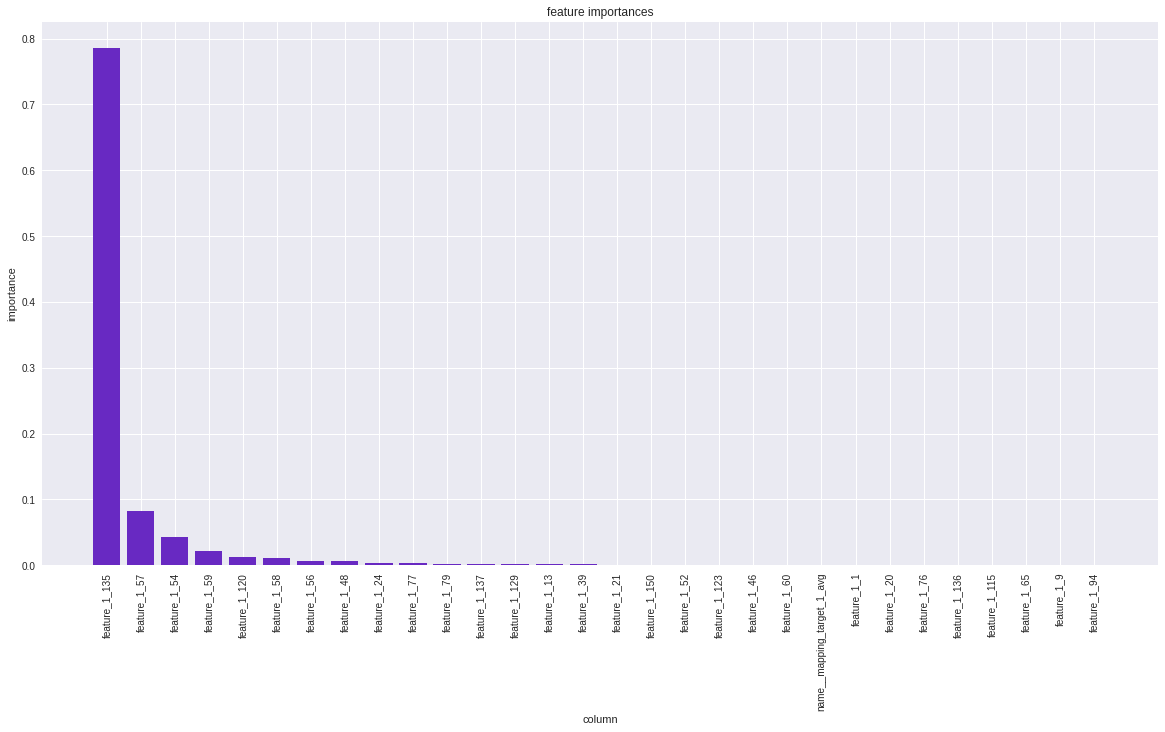

In [64]:
names, importances = pipe1.features.importances(target_num=0)

plt.subplots(figsize=(20, 10))

plt.bar(names[:30], importances[:30], color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

As we can see, a small number of features accounts for well over 90% of the predictive power. Therefore, if we take a look at the most important features, we will get a very good idea where the predictive power comes from:

In [65]:
pipe1.features.to_sql()[names[0]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_135";

CREATE TABLE "FEATURE_1_135" AS
SELECT NUM_MIN( t1."date" - t2."date" ) AS "feature_1_135",
       t1.rowid AS "rownum"
FROM "POPULATION__STAGING_TABLE_1" t1
LEFT JOIN "VIOLATIONS__STAGING_TABLE_3" t2
ON t1."business_id" = t2."business_id"
WHERE t2."date" <= t1."date"
GROUP BY t1.rowid;
```

In [66]:
pipe1.features.to_sql()[names[1]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_57";

CREATE TABLE "FEATURE_1_57" AS
SELECT EWMA_1D( t2."risk_category__mapping_1_target_1_avg", t1."date" - t2."date" ) AS "feature_1_57",
       t1.rowid AS "rownum"
FROM "POPULATION__STAGING_TABLE_1" t1
LEFT JOIN "VIOLATIONS__STAGING_TABLE_3" t2
ON t1."business_id" = t2."business_id"
WHERE t2."date" <= t1."date"
GROUP BY t1.rowid;
```

In [67]:
pipe1.features.to_sql()[names[2]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_54";

CREATE TABLE "FEATURE_1_54" AS
SELECT EWMA_1S( t2."risk_category__mapping_1_target_1_avg", t1."date" - t2."date" ) AS "feature_1_54",
       t1.rowid AS "rownum"
FROM "POPULATION__STAGING_TABLE_1" t1
LEFT JOIN "VIOLATIONS__STAGING_TABLE_3" t2
ON t1."business_id" = t2."business_id"
WHERE t2."date" <= t1."date"
GROUP BY t1.rowid;
```

What we can learn from these features is the following:

1) The health score depends on the number of violations at the LAST inspection (FEATURE_1_135).

2) The health score also depends on the severity of these violations (FEATURE_1_57, FEATURE_1_54). Note that EWMA is short for exponentially weighted moving average and is therefore an aggregation that gives greater emphasis to more recent data.

Of course, this is very much how we would expect a public health department to assign these scores. But what are the features that featuretools has come up with?

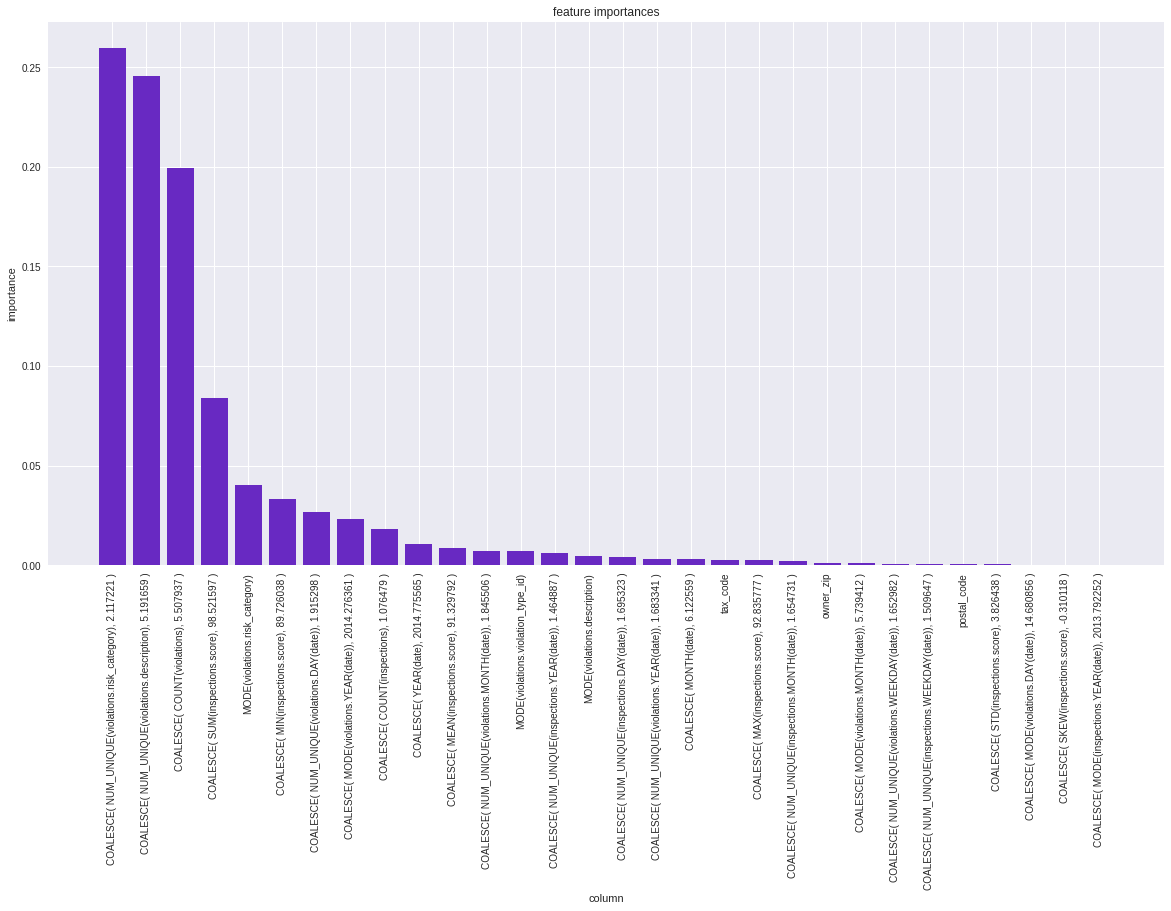

In [68]:
names, importances = pipe4.features.importances(target_num=0)

plt.subplots(figsize=(20, 10))

plt.bar(names[:30], importances[:30], color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

As we can see, featuretools cannot reproduce such a logic. It can calculate the number of violations and the number of unique violations, but it cannot assess their severity and it cannot differentiate between more recent violations and violations that happened a long time ago.

### 2.7 Discussion

For a more convenient overview, we summarize our results into a table.

Name                 | R-squared | RMSE | MAE
-------------------- | --------- | ---- | ----
getML: FastProp      |     97.0% | 1.45 | 0.53
getML: Relboost      |     97.2% | 1.41 | 0.45
getML: RelMT         |     97.4% | 1.35 | 0.3
featuretools         |     86.3% | 3.07 | 1.97

As we can see, these figures paint a very clear picture. All scores indicate that RelMT outperforms Relboost, which outperforms FastProp. All three algorithms outperform featuretools by a wide margin.

As we have seen in the previous section, the health score largely depends on the number of violations and their severity at the most recent inspection. However, featuretools cannot quite build features that reproduce this kind of logic.

## 3. Conclusion

We have benchmarked getML against featuretools on dataset related to health inspections of eateries in San Francisco. We have found that getML outperforms featuretools by a wide margin.

## References

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).

# Next Steps

This tutorial benchmarked getML against academic state-of-the-art algorithms from relational learning literature and getML's qualities with respect to categorical data.

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.